In [1]:
%load_ext autoreload
%autoreload 2

from autocvd import autocvd
autocvd(num_gpus = 1)

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
# import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import torch
from torch import nn
import torch.nn.functional as F

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

2025-05-16 19:23:37.126584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 19:23:37.143494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747416217.163232 2401410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747416217.169105 2401410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747416217.184989 2401410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Device: cuda


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import re

class DiskDataset(Dataset):
    def __init__(self, file_paths, file_type="npy", transform=None, ):
        """
        Args:
            file_paths (List[str]): List of paths to data files.
            file_type (str): Type of file to load ('npy', 'pt', or custom).
            transform (callable, optional): Optional transform to apply.
        """
        self.file_paths = self._filter_valid_paths(file_paths)
        self.file_type = file_type
        self.transform = transform

        path = self.file_paths[0]
        if self.file_type == "npz":
            x, theta = np.load(path)['x'], np.load(path)['theta']
            x, theta = torch.from_numpy(x), torch.from_numpy(theta)
        self.tensors = x.unsqueeze(0), theta.unsqueeze(0)
        print(self.tensors[0].shape, self.tensors[1].shape)

    def _filter_valid_paths(self, paths):
        valid_paths = []
        for path in paths:
            try:
                data = np.load(path)
                x, theta = data['x'], data['theta']
                if not np.isnan(x).any() and not np.isnan(theta).any():
                    valid_paths.append(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        return valid_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        
        if self.file_type == "npz":
            x, theta = np.load(path)['x'], np.load(path)['theta']
            x, theta = torch.from_numpy(x), torch.from_numpy(theta)
        elif self.file_type == "pt":
            data = torch.load(path)
        else:
            raise ValueError(f"Unsupported file type: {self.file_type}")

        if self.transform:
            data = self.transform(data)
        
        self.tensors = x, theta

        return x, theta


#load data
data_path = '/export/data/vgiusepp/odisseo_data/data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files_path_training = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 10_000
)

dataset_training = DiskDataset(files_path_training, file_type="npz", )
dataloader_training = DataLoader(dataset_training, batch_size=256, shuffle=True, num_workers=4)

for batch in dataloader_training:
    print(batch[0].shape, batch[1].shape)
    break

files_path_validation = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 11_000 and int(m.group(1)) >= 10_000
)

dataset_validation = DiskDataset(files_path_validation, file_type="npz", )
dataloader_validation = DataLoader(dataset_validation, batch_size=256, shuffle=False, num_workers=4)
for batch in dataloader_validation:
    print(batch[0].shape, batch[1].shape)
    break


files_path_test = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 12_000 and int(m.group(1)) >= 11_000
)

dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=256, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print(batch[0].shape, batch[1].shape)
    break

files_path_obs = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) == 60_000
)

x_obs = torch.from_numpy(np.load(files_path_obs[0])['x'])
theta_obs = torch.from_numpy(np.load(files_path_obs[0])['theta'])
print(theta_obs)

torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([256, 10000, 6]) torch.Size([256, 5])
torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([256, 10000, 6]) torch.Size([256, 5])
torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([256, 10000, 6]) torch.Size([256, 5])
tensor([9.8131e+00, 7.6439e+04, 1.9175e+00, 7.3798e+11, 1.6137e+01])


In [3]:
class DeepSetsEncoder(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=32):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [N, D] (unbatched) or [B, N, D] (batched)
        Returns:
            summary vector of shape [output_dim] or [B, output_dim]
        """
        if x.dim() == 2:
            # Unbatched input: [N_particles, 6]
            x_phi = self.phi(x)                  # [N, output_dim]
            summary = x_phi.mean(dim=0)          # [output_dim]
        elif x.dim() == 3:
            # Batched input: [B, N_particles, 6]
            B, N, D = x.shape
            x_phi = self.phi(x.view(-1, D))      # [B * N, output_dim]
            x_phi = x_phi.view(B, N, -1)         # [B, N, output_dim]
            summary = x_phi.mean(dim=1)          # [B, output_dim]
        else:
            raise ValueError(f"Expected shape (N, D) or (B, N, D), got {x.shape}")
        
        return summary
    
embedding_net = DeepSetsEncoder(hidden_dim=128, output_dim=128)

In [ ]:
# ltu-ili 

loader = ili.dataloaders.TorchLoader(
    train_loader=dataloader_training,
    val_loader=dataloader_validation,
)

trainer = ili.inference.InferenceRunner.load(
  backend = 'lampe',          # Choose a backend and inference engine (here, Neural Posterior Estimation)
  engine='NPE',               
  # define a prior
  prior = ili.utils.Uniform(low=[0.5, 1e3, 0.1, 5e11, 1.0], 
                            high=[10.0, 1e5, 2.0, 1.5e12, 20.0], 
                            device=device),
  # Define a neural network architecture (here, MAF)
  nets = [ili.utils.load_nde_lampe(engine='NPE', 
                                   model='maf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,)],
  device = device,
  train_args = {'stop_after_epochs': 2, 'max_epochs':10}
 
)

posterior, _ = trainer(loader)                  # Run training to map data -> parameters

samples = posterior.sample(                     # Generate 1000 samples from the posterior for input x[0]
  x=x_obs, shape=(1000,)
)


INFO:root:MODEL INFERENCE CLASS: NPE


INFO:root:Training model 1 / 1.
10 epochs [01:44, 10.42s/ epochs, loss=45.7, loss_val=45.7]
INFO:root:It took 107.29499292373657 seconds to train models.


TypeError: LampeEnsemble.sample() got an unexpected keyword argument 'sample_shape'

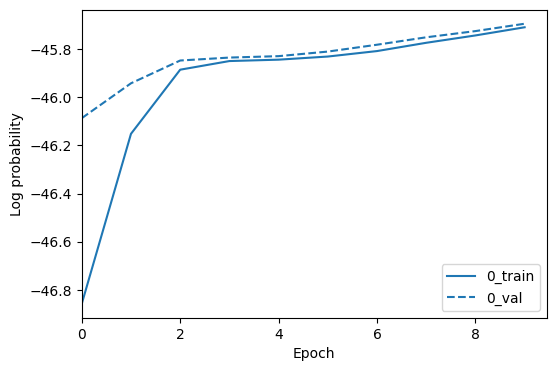

In [12]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(_):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

INFO:root:Sampling models with [1000] samples each.
Drawing 1000 posterior samples: 1294it [00:00, 66729.32it/s]            


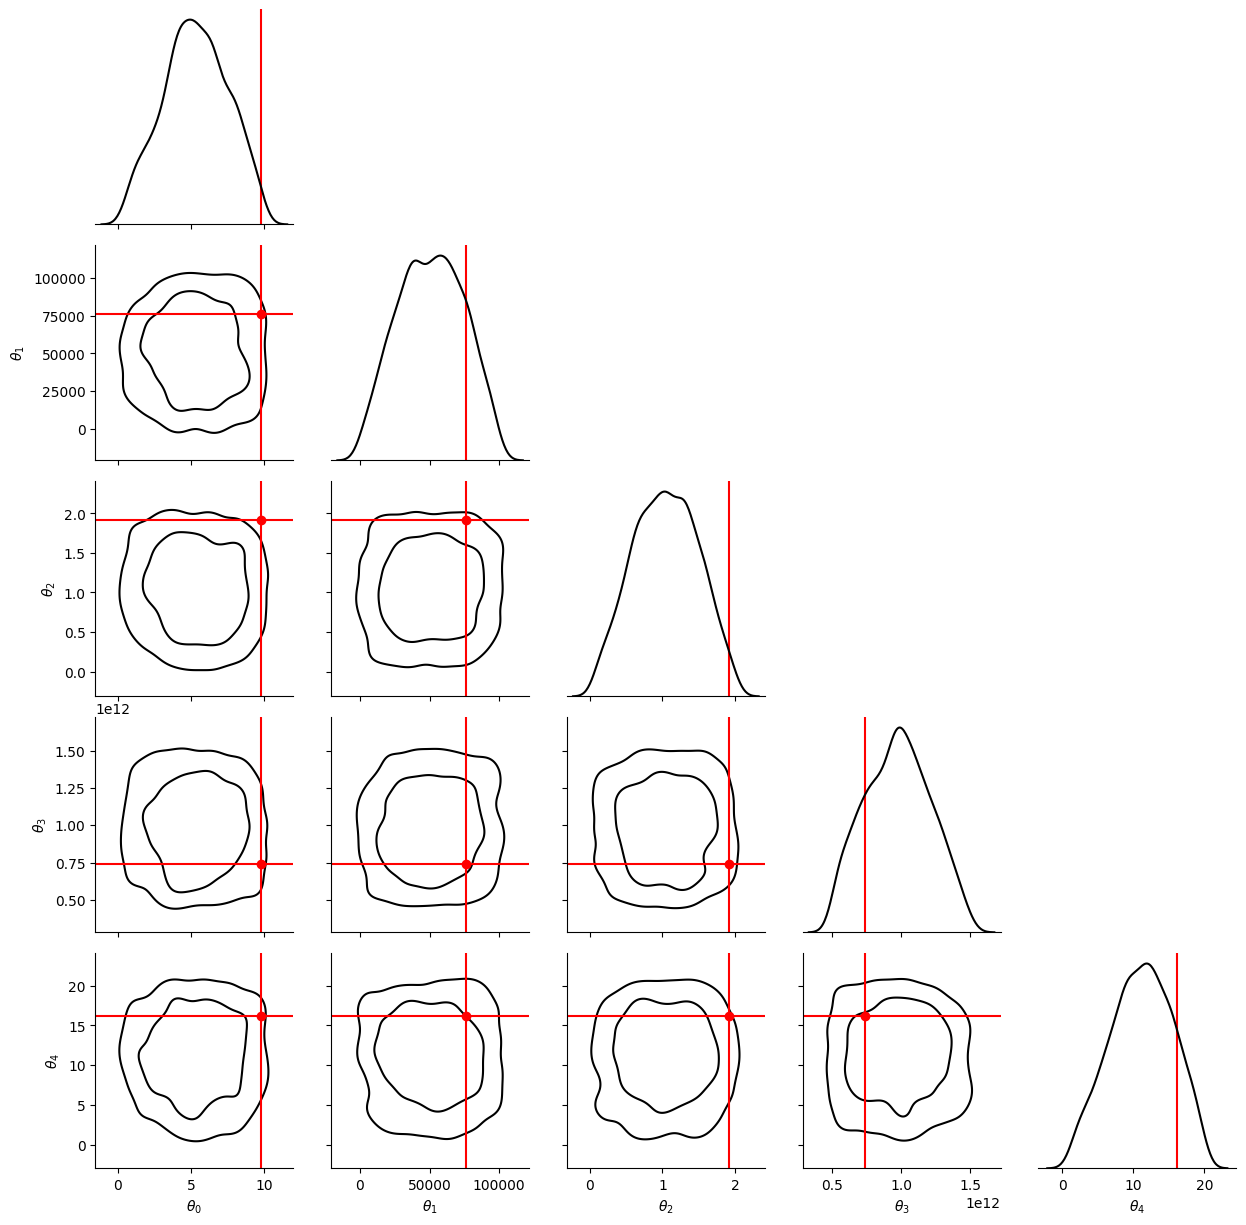

In [13]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(5)]
)
fig = metric(
    posterior=posterior,
    x_obs = x_obs, theta_fid=theta_obs,
)

In [21]:
files_path_test = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 61_000 and int(m.group(1)) >= 60_000
)

dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=256, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print(batch[0].shape, batch[1].shape)
    break

x = torch.tensor([a[0] for a in dataloader_test])
theta = torch.tensor([a[1] for a in dataloader_test])                 

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(5)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)


fig = metric(
    posterior=posterior,
    x=x, theta=theta
)

torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([256, 10000, 6]) torch.Size([256, 5])


ValueError: only one element tensors can be converted to Python scalars

In [22]:
np.array([a[0] for a in dataloader_test])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [24]:
[a.shape for a in dataloader_test]

AttributeError: 'list' object has no attribute 'shape'

In [26]:
np.array([a[0].reshape(-1, ) for a in dataloader_test ])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

2025-05-25 19:15:08.006430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 19:15:08.025449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748193308.046114 3858504 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748193308.051863 3858504 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748193308.067483 3858504 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Device: cuda
torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([64, 10000, 6]) torch.Size([64, 5])
torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([64, 10000, 6]) torch.Size([64, 5])
torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([64, 10000, 6]) torch.Size([64, 5])
tensor([9.3403e+00, 2.0320e+04, 1.2985e+00, 6.6980e+11, 1.5186e+01])


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
174 epochs [19:11,  6.62s/ epochs, loss=44.7, loss_val=45.4]   
INFO:root:Training model 2 / 2.
211 epochs [28:00,  7.96s/ epochs, loss=43.9, loss_val=44.3]
INFO:root:It took 2835.946707010269 seconds to train models.
INFO:root:Sampling models with [321, 679] samples each.
Drawing 321 posterior samples: 446it [00:00, 6095.94it/s]             
Drawing 679 posterior samples: 1295it [00:00, 27713.36it/s]           
INFO:root:Sampling models with [321, 679] samples each.
Drawing 321 posterior samples: 445it [00:00, 39659.71it/s]            
Drawing 679 posterior samples: 1262it [00:00, 36009.71it/s]           


torch.Size([1, 10000, 6]) torch.Size([1, 5])
torch.Size([64, 10000, 6]) torch.Size([64, 5])


ValueError: only one element tensors can be converted to Python scalars

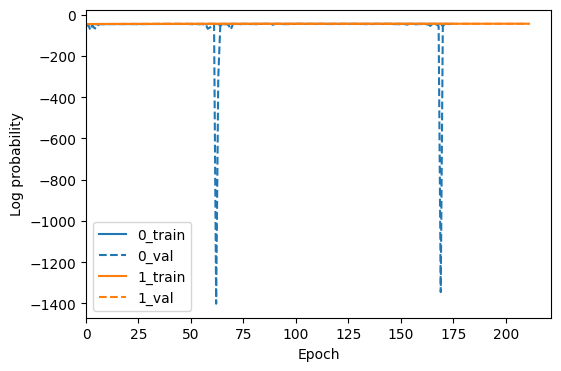

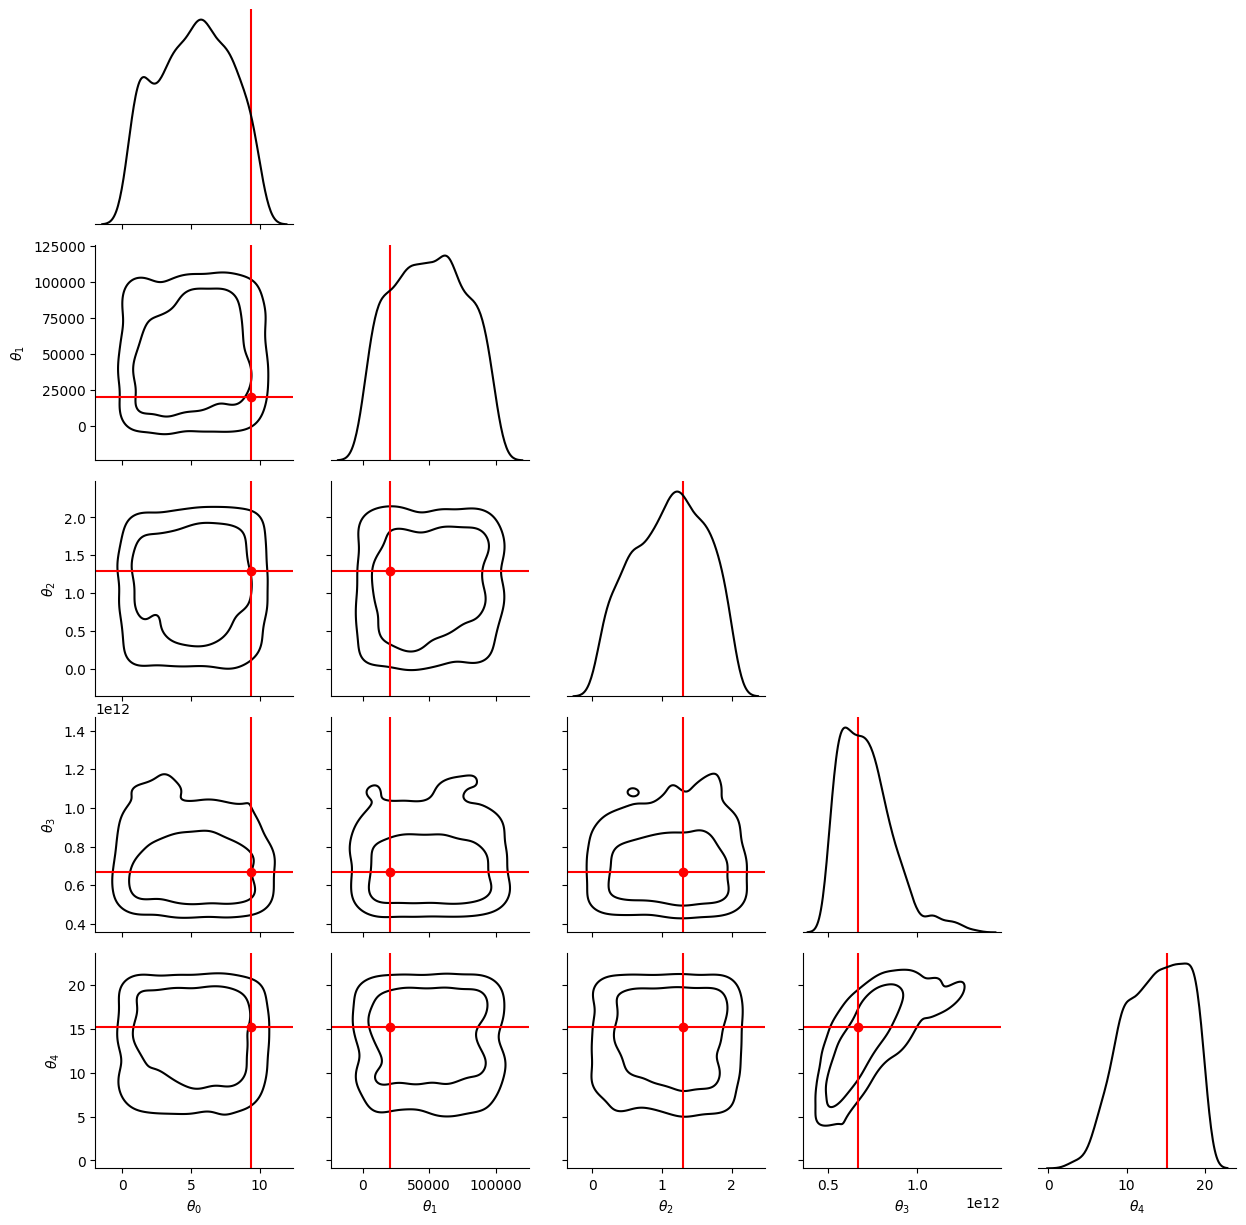

In [ ]:
# from autocvd import autocvd
# autocvd(num_gpus = 1)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9'

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
# import torch_geometric as pyg
import pandas as pd
import seaborn as sns
import tarp

import torch
from torch import nn
import torch.nn.functional as F

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorSamples, PosteriorCoverage)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import re

class DiskDataset(Dataset):
    def __init__(self, file_paths, file_type="npy", transform=None, ):
        """
        Args:
            file_paths (List[str]): List of paths to data files.
            file_type (str): Type of file to load ('npy', 'pt', or custom).
            transform (callable, optional): Optional transform to apply.
        """
        self.file_paths = self._filter_valid_paths(file_paths)
        self.file_type = file_type
        self.transform = transform

        path = self.file_paths[0]
        if self.file_type == "npz":
            x, theta = np.load(path)['x'], np.load(path)['theta']
            x, theta = torch.from_numpy(x), torch.from_numpy(theta)
        self.tensors = x.unsqueeze(0), theta.unsqueeze(0)
        print(self.tensors[0].shape, self.tensors[1].shape)

    def _filter_valid_paths(self, paths):
        valid_paths = []
        for path in paths:
            try:
                data = np.load(path)
                x, theta = data['x'], data['theta']
                if not np.isnan(x).any() and not np.isnan(theta).any():
                    valid_paths.append(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
        return valid_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        
        if self.file_type == "npz":
            x, theta = np.load(path)['x'], np.load(path)['theta']
            x, theta = torch.from_numpy(x), torch.from_numpy(theta)
        elif self.file_type == "pt":
            data = torch.load(path)
        else:
            raise ValueError(f"Unsupported file type: {self.file_type}")

        if self.transform:
            data = self.transform(data)
        
        self.tensors = x, theta

        return x, theta


#load data
data_path = '/export/data/vgiusepp/odisseo_data/data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files_path_training = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 5_000
)

dataset_training = DiskDataset(files_path_training, file_type="npz", )
dataloader_training = DataLoader(dataset_training, batch_size=64, shuffle=True, num_workers=4)

for batch in dataloader_training:
    print(batch[0].shape, batch[1].shape)
    break

files_path_validation = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 6_000 and int(m.group(1)) >= 5_000
)

dataset_validation = DiskDataset(files_path_validation, file_type="npz", )
dataloader_validation = DataLoader(dataset_validation, batch_size=64, shuffle=False, num_workers=4)
for batch in dataloader_validation:
    print(batch[0].shape, batch[1].shape)
    break


files_path_test = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 6_100 and int(m.group(1)) >= 6_000
)

dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print(batch[0].shape, batch[1].shape)
    break

files_path_obs = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) == 6_101
)

x_obs = torch.from_numpy(np.load(files_path_obs[0])['x'])
theta_obs = torch.from_numpy(np.load(files_path_obs[0])['theta'])
print(theta_obs)


class DeepSetsEncoder(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=32):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [N, D] (unbatched) or [B, N, D] (batched)
        Returns:
            summary vector of shape [output_dim] or [B, output_dim]
        """
        if x.dim() == 2:
            # Unbatched input: [N_particles, 6]
            x_phi = self.phi(x)                  # [N, output_dim]
            summary = x_phi.mean(dim=0)          # [output_dim]
        elif x.dim() == 3:
            # Batched input: [B, N_particles, 6]
            B, N, D = x.shape
            x_phi = self.phi(x.view(-1, D))      # [B * N, output_dim]
            x_phi = x_phi.view(B, N, -1)         # [B, N, output_dim]
            summary = x_phi.mean(dim=1)          # [B, output_dim]
        else:
            raise ValueError(f"Expected shape (N, D) or (B, N, D), got {x.shape}")
        
        return summary
    
embedding_net = DeepSetsEncoder(hidden_dim=128, output_dim=128)


# ltu-ili 

loader = ili.dataloaders.TorchLoader(
    train_loader=dataloader_training,
    val_loader=dataloader_validation,
)

trainer = ili.inference.InferenceRunner.load(
  backend = 'lampe',          # Choose a backend and inference engine (here, Neural Posterior Estimation)
  engine='NPE',               
  # define a prior
  prior = ili.utils.Uniform(low=[0.5, 1e3, 0.1, 5e11, 1.0], 
                            high=[10.0, 1e5, 2.0, 1.5e12, 20.0], 
                            device=device),
  # Define a neural network architecture (here, MAF)
  nets = [ili.utils.load_nde_lampe(engine='NPE', 
                                   model='maf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,),
         ili.utils.load_nde_lampe(engine='NPE', 
                                   model='nsf', 
                                   embedding_net=embedding_net, 
                                   x_normalize=True,
                                   theta_normalize=True,)],
  device = device,
#   train_args = {'stop_after_epochs': 2, 'max_epochs':10}
)

posterior, summary = trainer(loader)                  # Run training to map data -> parameters

samples = posterior.sample(                     # Generate 1000 samples from the posterior for input x[0]
  x=x_obs, shape=(1000,)
)

# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summary):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

fig.savefig("./test_plot/log_probabilities.pdf", bbox_inches='tight', format='pdf')

# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(5)]
)
fig = metric(
    posterior=posterior,
    x_obs = x_obs, theta_fid=theta_obs,
)
fig.savefig("./test_plot/posterior_plot.pdf", bbox_inches='tight', format='pdf')

files_path_test = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 61_000 and int(m.group(1)) >= 60_000
)

dataset_test = DiskDataset(files_path_test, file_type="npz", )
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)
for batch in dataloader_test:
    print(batch[0].shape, batch[1].shape)
    break

def dataloader_to_tensors(dataloader):
    xs, thetas = [], []
    for x_batch, theta_batch in dataloader:
        xs.append(x_batch)
        thetas.append(theta_batch)
    x_tensor = torch.cat(xs, dim=0)
    theta_tensor = torch.cat(thetas, dim=0)
    return x_tensor, theta_tensor

x, theta = dataloader_to_tensors(dataloader_test)

# x = torch.tensor([a[0] for a in dataloader_test])
# theta = torch.tensor([a[1] for a in dataloader_test])                 

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(5)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)


fig = metric(
    posterior=posterior,
    x=x, theta=theta
)

plot_list = ["coverage", "histogram", "predictions", "tarp"]
for i, f in enumerate(fig):
    name= plot_list[i]
    f.savefig(f"./test_plot/posterior_coverage_{name}.pdf", bbox_inches='tight', format='pdf')

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


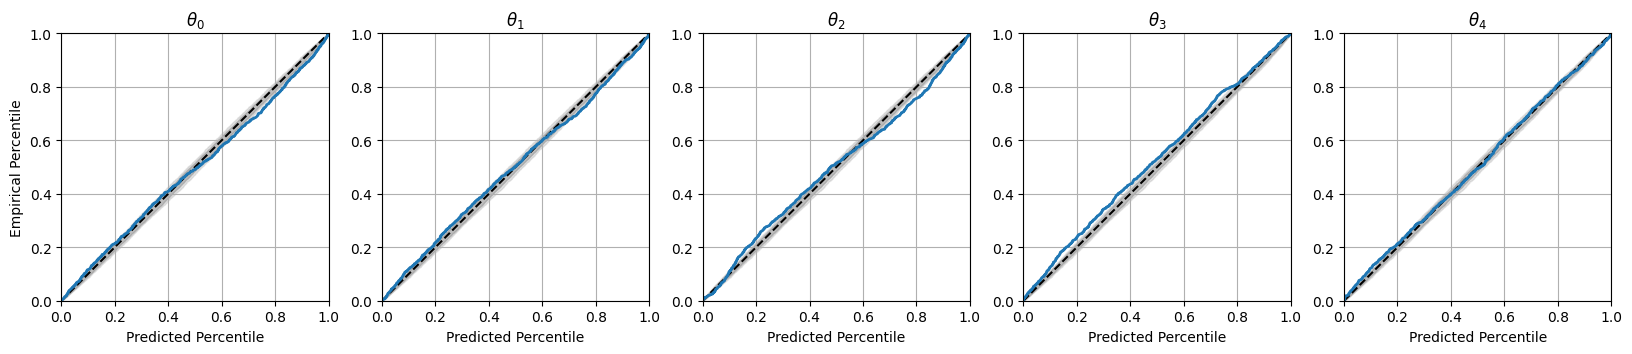

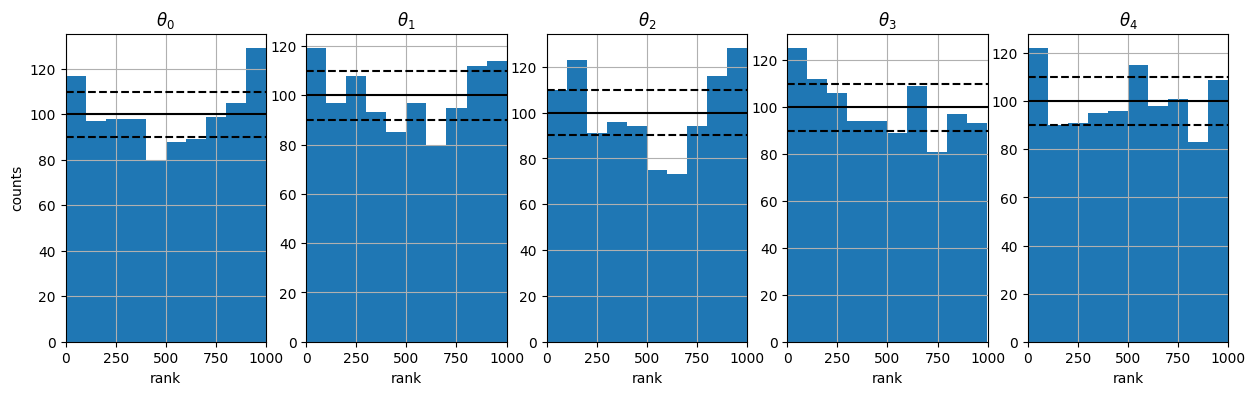

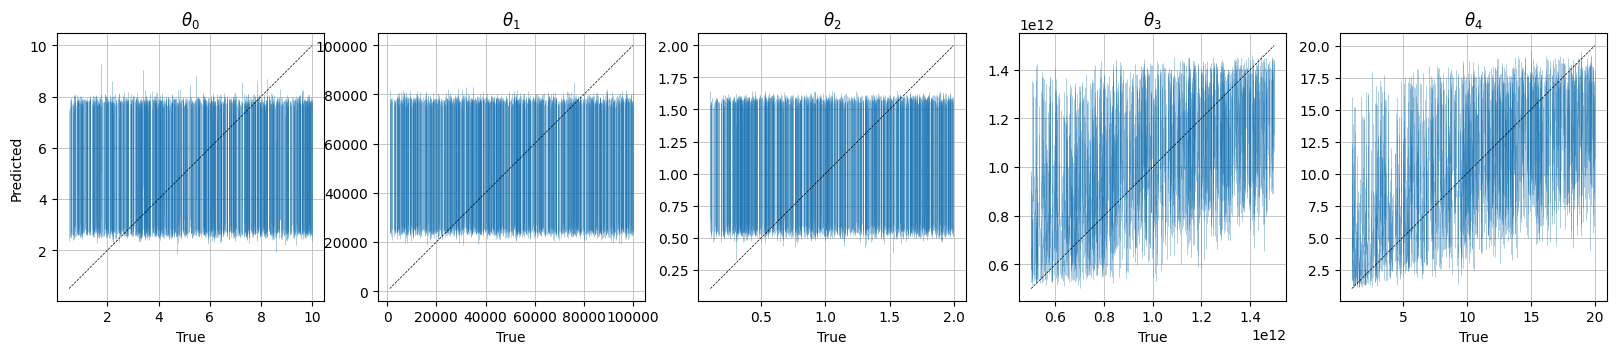

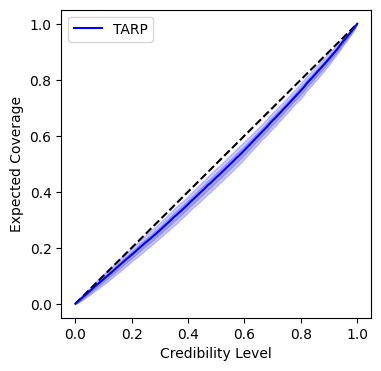

In [2]:

def dataloader_to_tensors(dataloader):
    xs, thetas = [], []
    for x_batch, theta_batch in dataloader:
        xs.append(x_batch)
        thetas.append(theta_batch)
    x_tensor = torch.cat(xs, dim=0)
    theta_tensor = torch.cat(thetas, dim=0)
    return x_tensor, theta_tensor

x, theta = dataloader_to_tensors(dataloader_test)

# x = torch.tensor([a[0] for a in dataloader_test])
# theta = torch.tensor([a[1] for a in dataloader_test])                 

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(5)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)


fig = metric(
    posterior=posterior,
    x=x, theta=theta
)

plot_list = ["coverage", "histogram", "predictions", "tarp"]
for i, f in enumerate(fig):
    name= plot_list[i]
    f.savefig(f"./test_plot/posterior_coverage_{name}.pdf", bbox_inches='tight', format='pdf')